In [ ]:
#!pip3 install torch torchvision torchaudio
#!pip3 install -U scikit-learn scipy matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, models, transforms
import torch.nn.functional as nnF
from sklearn import metrics as skl_metrics
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, train_test_split
import pandas as pd
import numpy as np
import numpy.typing as npt
import csv
import os
import time
import copy
import glob
import json
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

#!pip install grad-cam
#from pytorch_grad_cam import GradCAM, EigenCAM, FullGrad
#from pytorch_grad_cam.utils.image import show_cam_on_image

## This allows inbuilt cudnn auto-tuner to find the best algorithm to use for your hardware
import torch.backends.cudnn as cudnn
cudnn.benchmark = True

In [ ]:
# For google drive connection in order to load the dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## General parameters
verbose = False
check = False

random_state = 42

#toxoFolderPath = '/data/raw/Toxoplasmosis/classification'
toxoFolderPath = '/content/drive/MyDrive/REU/mini_eye_data'

fileName_BM     = ['_B_', '_M_']
path_BM         = ['benign', 'malignant']
magnifications  = ['40X', '100X', '200X', '400X']

## Enumerates and dictionaries
folds = ['fold-0', 'fold-1', 'fold-2', 'fold-3', 'fold-4']
class_names = [ 'Bening', 'Malignant']

## Execution parameters
num_epochs = 100     # Epochs to be trained
#lr=0.001            # Learning rate for the training
lr=1e-3
#momentum=0.9        # Momentum for the training
returned='best'     # Model to be returned in the training. ['last' (default), 'best']


In [ ]:
class MyDataset(Dataset):
    """Class that contains a dataset.

    Attributes
    ----------
    data : numpy.ndarray
        Array containing the data of the dataset
    targets : numpy.ndarray
        Array containing tha targets associated with the data
    """
    def __init__(self, data:npt.NDArray, targets:npt.NDArray):
        self.data=data
        self.targets=targets

    def __len__(self):
        """Returns the number of data points
        """
        return self.data.shape[0]

    def __getitem__(self, idx:int):
        x = self.data[idx]
        y = self.targets[idx]
        return x, y

class MyLazyImageDataset(Dataset):
    """Class that contains an image dataset.
    It has lazy loading of the images, saving system memory at the cost of time.

    Attributes
    ----------
    data : numpy.ndarray
        Array containing the data of the dataset
    targets : numpy.ndarray
        Array containing tha targets associated with the data
    transformations : torchvision.transforms
        Transformations to be applied to the images.

    """
    def __init__(self, data:npt.NDArray, targets:npt.NDArray, transformations:torchvision.transforms):
        self.data=data
        self.targets=targets
        self.transformations=transformations

    def __len__(self):
        """Returns the number of data points
        """
        return self.data.shape[0]

    def __getitem__(self, idx):
        x = self.transformations(Image.open(self.data[idx]))
        y = self.targets[idx]
        return x, y


class DataContainer:
    """Class that contains a dataset. Allows data splitting plus dataset and dataloader creation
    Class .

    Attributes
    ----------
    data : numpy.ndarray
        Array containing the data of the dataset
    targets : numpy.ndarray
        Array containing tha targets associated with the data

    Methods
    -------

    """
    data = []
    targets = []

    train_index = []
    final_val_index = []
    test_index = []
    kfold_indexes = []

    def __init__(self,
                 data:npt.NDArray,
                 targets:npt.NDArray,
                 split_test:bool=True,
                 test_size:float=0.1,
                 split_final_val:bool=True,
                 final_val_size:float=0.1,
                 split_kfold:bool=True,
                 k_splits:int=5,
                 random_state:int=None):
        self.data = data
        self.targets = targets
        self.split_test=split_test
        self.test_size=test_size
        self.split_final_val=split_final_val
        self.final_val_size=final_val_size
        self.split_kfold=split_kfold
        self.k_splits = k_splits
        self.random_state = random_state

        # Generate test indexes over the dataset
        if self.split_test:
            test_len=round(self.data.shape[0] * self.test_size)
            sss = StratifiedShuffleSplit(n_splits=1, test_size=test_len, random_state=self.random_state)
            self.train_index, self.test_index = list(sss.split(self.data, self.targets))[0]
        else:
            self.train_index, self.test_index = np.array(range(0, self.data.shape[0])), []

        # Generate final-validation indexes over the dataset.
        # Intersection between taining and final-validation must be empty
        if self.split_final_val:
            # Number of examples to be separated refered to the original data size
            final_val_len=round(self.data.shape[0] * self.final_val_size)
            sss = StratifiedShuffleSplit(n_splits=1, test_size=final_val_len, random_state=self.random_state)
            # The final_val is seprated from the data minus test subset.
            train_index, final_val_index = list(sss.split(self.data[self.train_index], self.targets[self.train_index]))[0]
            # But the indexes obtained must be refered to the original dataset and not the training subset
            self.final_val_index = self.train_index[final_val_index]
            self.train_index = self.train_index[train_index]
        else:
            self.train_index, self.final_val_index = self.train_index, []

        # Generate train-validation k-fold indexes over the training subset
        if self.split_kfold:
            strtfdKFold = StratifiedKFold(n_splits=self.k_splits, shuffle=True, random_state=self.random_state)
            self.kfold_indexes = list(strtfdKFold.split(self.data[self.train_index], self.targets[self.train_index]))
        else:
            self.kfold_indexes = []

    # This function is needed for the possible situation in which a lazy kind of dataset may be needed
    # (for instance for huge image datasets that need lazy load due to memory constraints)
    def getDataset_(self, data:npt.NDArray, targets:npt.NDArray):
        return MyDataset(data, targets)


    def save_partition (self, file_path:str):
        """Saves the partition of the dataset in the given file path
        """
        toSave = (self.train_index, self.final_val_index, self.test_index, self.kfold_indexes)
        with open(file_path, 'wb') as file:
            pd.to_pickle(toSave, file)
            print(f'Object successfully saved to "{file_path}"')

    def load_partition (self, file_path:str):
        """Loads the partition of the dataset from the given file path
        """
        self.train_index, self.final_val_index, self.test_index, self.kfold_indexes = pd.read_pickle(file_path)


    ############### Checks ###############

    def check_intersection (self, verbose:bool=False):
        """Method that returns if there is any element of one subset (train, final_val, test) in the others.
        If verbose is True, prints tuple (test_in_train, val_in_train, val_in_test)

        Returns
        ----------
            True if the intersections are 0, False otherwise
        """
        test_in_train = sum(1 if x in self.train_index else 0 for x in self.test_index)
        val_in_train = sum(1 if x in self.final_val_index else 0 for x in self.test_index)
        val_in_test = sum(1 if x in self.train_index else 0 for x in self.final_val_index)
        if verbose: print (test_in_train, val_in_train, val_in_test)
        return test_in_train + val_in_train + val_in_test == 0

    def check_folds (self, verbose:bool=False):
        """Method that returns if the folds were correctly formed: right size AND validation not intersecting AND sum(validation) == training
        If verbose is True, prints tuple (size_ok, val_intersection_ok, all_val_eq_training_ok)

        Returns
        ----------
            True if the intersections are 0, False otherwise
        """
        if self.kfold_indexes is None or len(self.kfold_indexes) == 0:
            raise FileNotFoundError('The controller was created without kfold splitting')
        size_ok = True
        val_acum = []
        val_intersection = 0
        for (train, val) in self.kfold_indexes:
            if train.shape[0] + val.shape[0] != self.train_index.shape[0]:
                size_ok = False
            for v in val:
                if v in val_acum:
                    val_intersection += 1
                else:
                    val_acum.append(v)
        val_intersection_ok = val_intersection==0
        val_acum_ok = len(val_acum)==self.train_index.shape[0]
        if verbose: print (size_ok, val_intersection_ok, val_acum_ok)
        return size_ok and val_intersection_ok and val_acum_ok

    ############### Data ###############

    def get_data(self):
        return (self.data, self.targets)

    def get_full_train(self):
        return (self.data[self.train_index], self.targets[self.train_index])

    def get_final_val(self):
        if self.final_val_index is None or self.final_val_index.shape[0] == 0:
            raise FileNotFoundError('The controller was created without final_val splitting')
        return (self.data[self.final_val_index], self.targets[self.final_val_index])

    def get_test(self):
        if self.test_index is None or self.test_index.shape[0] == 0:
            raise FileNotFoundError('The controller was created without test splitting')
        return (self.data[self.test_index], self.targets[self.test_index])

    ############### Indexes ###############

    def get_fold_indexes (self, fold:int) -> tuple[list[int], list[int]]:
        if self.kfold_indexes is None or len(self.kfold_indexes) == 0:
            raise FileNotFoundError('The controller was created without kfold splitting')
        fold_train_indexes, fold_val_indexes = self.kfold_indexes[fold]
        train_indexes = self.train_index[fold_train_indexes]
        val_indexes = self.train_index[fold_val_indexes]
        return (train_indexes, val_indexes)

    ############### Dataset ###############

    def get_data_dataset(self) -> Dataset:
        data, targets = self.get_data()
        data_dataset = self.getDataset_(data, targets)
        return data_dataset

    def get_full_train_dataset(self) -> Dataset:
        train_data, train_targets = self.get_full_train()
        return self.getDataset_(train_data, train_targets)

    def get_final_val_dataset(self) -> Dataset:
        final_val_data, final_val_targets = self.get_final_val()
        return self.getDataset_(final_val_data, final_val_targets)

    def get_test_dataset(self) -> Dataset:
        test_data, test_targets = self.get_test()
        return self.getDataset_(test_data, test_targets)

    def get_fold_datasets (self, fold:int) -> tuple[Dataset, Dataset]:
        train_indexes, val_indexes = self.get_fold_indexes(fold)
        train_dataset = self.getDataset_(self.data[train_indexes], self.targets[train_indexes])
        val_dataset = self.getDataset_(self.data[val_indexes], self.targets[val_indexes])
        return (train_dataset, val_dataset)

    ############### Dataloader ###############

    def get_data_dataloader(self, batch_size:int=32, shuffle:bool=False, num_workers:int=2) -> DataLoader:
        """Returns a dataloader with the full data.

        Args
        ----------
        batch_size : int
            Size of the batch. Optional. Default 32
        shuffle : bool
            If True, the order of the examples will be random. Optional. Default False
        num_workers: int
            Number of process to use. Optional. Default 2
        """
        data_dataset = self.get_data_dataset()
        return DataLoader(data_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

    def get_full_train_dataloader(self, batch_size:int=32, shuffle:bool=False, num_workers:int=2) -> DataLoader:
        """Returns a dataloader with the full training subset.

        Args
        ----------
        batch_size : int
            Size of the batch. Optional. Default 32
        shuffle : bool
            If True, the order of the examples will be random. Optional. Default False
        num_workers: int
            Number of process to use. Optional. Default 2
        """
        train_dataset = self.get_full_train_dataset()
        return DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

    def get_final_val_dataloader(self, batch_size:int=32, shuffle:bool=False, num_workers:int=2) -> DataLoader:
        """Returns a dataloader with the final validation subset.

        Args
        ----------
        batch_size : int
            Size of the batch. Optional. Default 32
        shuffle : bool
            If True, the order of the examples will be random. Optional. Default False
        num_workers: int
            Number of process to use. Optional. Default 2
        """
        final_val_dataset = self.get_final_val_dataset()
        return DataLoader(final_val_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

    def get_test_dataloader(self, batch_size:int=32, shuffle:bool=True, num_workers:int=2) -> DataLoader:
        """Returns a dataloader with the test subset.

        Args
        ----------
        batch_size : int
            Size of the batch. Optional. Default 32
        shuffle : bool
            If True, the order of the examples will be random. Optional. Default False
        num_workers: int
            Number of process to use. Optional. Default 2
        """
        test_dataset = self.get_test_dataset()
        return DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

    def get_fold_dataloaders(self, fold:int, batch_size:int=32, shuffle:bool=True, num_workers:int=2) -> tuple[DataLoader, DataLoader]:
        train_dataset, val_dataset = self.get_fold_datasets(fold)
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
        return (train_dataloader, val_dataloader)


class ImageFolderDataContainer(DataContainer):
    """Class to process the extraction of a image dataset from a folder path.
    The labels are extracted from the image path as the index of pathLabelsList
    Extends DataContainer.
    Allows data splitting plus dataset and dataloader creation.

    Attributes
    ----------
    data : numpy.ndarray
        Array containing the data of the dataset
    targets : numpy.ndarray
        Array containing tha targets associated with the data
    filepaths: numpy.ndarray[str]
        Array with the paths of the images

    Methods
    -------

    """
    filepaths = []

    def __init__(self,
                 folderPath:str,
                 extension:str,
                 pathLabelsList: list[str],
                 lazy:bool=False,
                 split_test:bool=True,
                 test_size:float=0.1,
                 split_final_val:bool=True,
                 final_val_size:float=0.1,
                 split_kfold:bool=True,
                 k_splits:int=5,
                 random_state:int=None,
                 transformations:bool=None):
        self.lazy=lazy
        self.transformations = transformations
        if self.transformations is None:
            self.transformations = transforms.ToTensor()
        data, labels = self.extract_data(folderPath, extension, pathLabelsList)
        super().__init__(data=data,
                         targets=labels,
                         split_test=split_test,
                         test_size=test_size,
                         split_final_val=split_final_val,
                         final_val_size=final_val_size,
                         split_kfold=split_kfold,
                         k_splits=k_splits,
                         random_state=random_state)



    def extract_data (self, folderPath:str, extension:str, pathLabelsList: list[str]) -> tuple[npt.NDArray, npt.NDArray]:
        """Function that extract the data from the given path in a recursive way.
        """
        # Take the paths of all images for that magnification in the given folder and subfolders and short them alphabetically
        filepaths = glob.glob(folderPath + "/**/*" + extension.lower(), recursive=True)
        filepaths.extend(glob.glob(folderPath + "/**/*" + extension.upper(), recursive=True))
        filepaths = sorted(filepaths, key=lambda s: os.path.split(s)[-1])

        # Read all images and extract their labels from the path
        images = filepaths
        if not self.lazy:
            images = [np.asarray(self.transformations(Image.open(fpath))) for fpath in images]
        labels=[]
        possibleLabelsLength = len(pathLabelsList)
        #print(len(filepaths))
        for fpath in filepaths:
            for i in range(0, possibleLabelsLength):
                if pathLabelsList[i] in fpath:
                    labels.append(i)
                    break

        # Store filepaths, and return images and labels
        self.filepaths = np.asarray(filepaths)
        data = np.asarray(images)
        labels = np.asarray(labels)

        return data, labels

    def getDataset_(self, data:npt.NDArray, targets:npt.NDArray) -> Dataset:
        """Function intended for huge image datasets that need lazy load due to memory constraints, instanties a different Dataset class

        Args
        ----------
        data: : numpy.ndarray
            Array of images or paths of images depending of if it has been created as lazy or not
        targets : numpy.ndarray
            Array of target values of the data

        Returns
        ----------
        Dataset:
            Implementation of the class torch.utils.data.Dataset. It will have lazy loading if the controller has been instantiated as such.
        """
        if not self.lazy:
            return MyDataset(data, targets)
        else:
            return MyLazyImageDataset(data, targets, self.transformations)


    ############### Image paths ###############

    def get_data_paths(self):
        return self.filepaths

    def get_full_train_paths(self):
        return self.filepaths[self.train_index]

    def get_final_val_paths(self):
        if self.final_val_index is None or self.final_val_index.shape[0] == 0:
            raise FileNotFoundError('The controller was created without final_val splitting')
        return self.filepaths[self.final_val_index]

    def get_test_paths(self):
        if self.test_index is None or self.test_index.shape[0] == 0:
            raise FileNotFoundError('The controller was created without test splitting')
        return self.filepaths[self.test_index]

    def get_fold_paths (self, fold:int):
        train_indexes, val_indexes = self.get_fold_indexes(fold)
        train_paths = self.filepaths[train_indexes]
        val_paths = self.filepaths[val_indexes]
        return (train_paths, val_paths)


    ############### Save images ###############

    def save_transformed_images (self, indexes=[0], folder_path="", base_name="", extension=".png", verbose:bool=False):
        for index in indexes:
            if not os.path.exists(folder_path):
                os.makedirs(folder_path)
            filename, _ = os.path.splitext(os.path.split(self.filepaths[index])[-1])
            new_file_path = os.path.join(folder_path, base_name + filename + extension)

            if not self.lazy:
                img = self.data[index]
            else:
                img = np.asarray(self.transformations(Image.open(self.data[index])))

            plt.imshow(img.transpose((1, 2, 0)))
            if verbose:
                print ("saving image to to " + new_file_path)
            plt.savefig(new_file_path, bbox_inches='tight')
            if verbose:
                print ("saved plot to " + new_file_path)
            plt.close()


class BreakHisDataContainer(ImageFolderDataContainer):
    """Class for loading the BreakHis dataset from a Path. Extends ImageFolderDataContainer.
    The labels are extracted from the image path with 'benign' = 0  and 'malignant' = 1
    """
    pathLabelsList = ['benign', 'malignant']
    extension = ".png"

    def __init__(self,
                 folderPath:str,
                 lazy:bool=False,
                 magnification:str="400X",
                 split_test:bool=True,
                 test_size:float=0.1,
                 split_final_val:bool=True,
                 final_val_size:float=0.1,
                 split_kfold:bool=True,
                 k_splits:int=5,
                 random_state:int=None,
                 transformations:torchvision.transforms=None):
        self.magnification=magnification
        super().__init__(folderPath=folderPath,
                         extension=self.extension,
                         pathLabelsList=self.pathLabelsList,
                         lazy=lazy,
                         split_test=split_test,
                         test_size=test_size,
                         split_final_val=split_final_val,
                         final_val_size=final_val_size,
                         split_kfold=split_kfold,
                         k_splits=k_splits,
                         random_state=random_state,
                         transformations=transformations)

    def extract_data (self, folderPath:str, extension:str, pathLabelsList: list[str]) -> tuple[npt.NDArray, npt.NDArray]:
        # Take the paths of all images for that magnification in the given folder and subfolders and short them alphabetically
        filepaths = glob.glob(folderPath + "/**/*" + extension, recursive=True)
        #print(filepaths)
        if self.magnification != "ALL":
            filepaths = [fpath for fpath in filepaths if self.magnification in fpath]
        filepaths = sorted(filepaths, key=lambda s: os.path.split(s)[-1])

        # Read all images and extract their labels from the path
        images = filepaths
        if not self.lazy:
            images = [np.asarray(self.transformations(Image.open(fpath))) for fpath in images]
        labels=[]
        possibleLabelsLength = len(pathLabelsList)
        for fpath in filepaths:
            for i in range(0, possibleLabelsLength):
                if pathLabelsList[i] in fpath:
                    labels.append(i)
                    break

        # Store filepaths, and return images and labels
        self.filepaths = np.asarray(filepaths)
        data = np.asarray(images)
        labels = np.asarray(labels)

        return data, labels


class BreakHisDataContainerPatientMulticlass(BreakHisDataContainer):
    """Class for loading the BreakHis dataset from a Path. Extends BreakHisDataContainer.
    The labels are extracted from the extraction ID
    """
    def extract_data (self, folderPath:str, extension:str, pathLabelsList: list[str]) -> tuple[npt.NDArray, npt.NDArray]:
        # Take the paths of all images for that magnification in the given folder and subfolders and short them alphabetically
        filepaths = glob.glob(folderPath + "/**/*" + extension, recursive=True)
        if self.magnification != "ALL":
            filepaths = [fpath for fpath in filepaths if self.magnification in fpath]
        filepaths = sorted(filepaths, key=lambda s: os.path.split(s)[-1])

        # Read all images and extract their labels from the path
        images = filepaths
        if not self.lazy:
            images = [np.asarray(self.transformations(Image.open(fpath))) for fpath in images]
        slide_ids = [(fpath.split("/")[-3]).split("-")[-1] for fpath in self.filepaths]
        unique_ids = list(set(slide_ids))
        labels = [unique_ids.index(id) for id in slide_ids]

        # Store filepaths, and return images and labels
        self.filepaths = np.asarray(filepaths)
        data = np.asarray(images)
        labels = np.asarray(labels)

        return data, labels

class AntsAndBeesDataContainer(ImageFolderDataContainer):
    """Image Folder Data Container for Hymenoptera dataset. Extends ImageFolderDataContainer.
    The labels are extracted from the image path with 'ants' = 0  and 'bees' = 1
    """
    pathLabelsList = ['ants', 'bees']
    extension=".jpg"
    def __init__(self,
                 folderPath:str,
                 lazy:bool=False,
                 split_test:bool=True,
                 test_size=0.1,
                 split_final_val:bool=True,
                 final_val_size=0.1,
                 split_kfold:bool=True,
                 k_splits:int=5,
                 random_state:int=None,
                 transformations:torchvision.transforms=None):

        super().__init__(folderPath=folderPath,
                         extension=self.extension,
                         pathLabelsList=self.pathLabelsList,
                         lazy=lazy,
                         split_test=split_test,
                         test_size=test_size,
                         split_final_val=split_final_val,
                         final_val_size=final_val_size,
                         split_kfold=split_kfold,
                         k_splits=k_splits,
                         random_state=random_state,
                         transformations=transformations)


class ToxoDataContainer(ImageFolderDataContainer):
    pathLabelsList = ['unhealthy', 'healthy']
    extension=".jpg"
    def __init__(self,
                 folderPath:str,
                 lazy:bool=False,
                 split_test:bool=True,
                 test_size=0.1,
                 split_final_val:bool=True,
                 final_val_size=0.1,
                 split_kfold:bool=True,
                 k_splits:int=5,
                 random_state:int=None,
                 transformations:torchvision.transforms=None):

        super().__init__(folderPath=folderPath,
                         extension=self.extension,
                         pathLabelsList=self.pathLabelsList,
                         lazy=lazy,
                         split_test=split_test,
                         test_size=test_size,
                         split_final_val=split_final_val,
                         final_val_size=final_val_size,
                         split_kfold=split_kfold,
                         k_splits=k_splits,
                         random_state=random_state,
                         transformations=transformations)


In [ ]:
class TrainingController:
    """Class used to manage the training of a model plus some utilities.

    Attributes
    ----------
    criterion : torch.nn.Module
        Loss function to be executed during the training backward pass

    max_epochs : int
        Maximum number of epoch to train

    returned : str
        Defines if the returned model and metrics are the ones for the 'last' or 'best' epoch

    metric : str
        Defines wich of the computed metrics is going to be used to compare epoch results

    plot_evolution : bool
        Flag for showing or not a plot with the epoch evolution at the end of the training

    reevaluate_training : bool
        Flag for re-evaluation to obtain the metrics over all the training set in each epoch, or using those result obtained during training (default True)

    verbose : bool
        Level of detail printed during training (default False)
    """

    def __init__(self,
                 criterion:nn.Module,
                 max_epochs:int=25,
                 returned:str='best',
                 metric:str='f1',
                 plot_evolution:bool=True,
                 reevaluate_training:bool=True,
                 verbose:bool=False):
        """Constructor

        Initializes the instance of the training controller

        Args
        ----------
        criterion : torch.nn.Module
            Loss function to be executed duering training to to the backward pass

        max_epochs : int, default = 25
            Maximum number of epoch to train

        returned : str, default = 'best'
            Defines if the returned model and metrics are the ones for the 'last' or 'best' epoch

        metric : str, default = 'f1'
            Defines wich of the computed metrics is going to be used to compare epoch results

        plot_evolution : bool, default = True
            Flag for showing or not a plot with the epoch evolution at the end of the training

        reevaluate_training : bool, default = True
            Flag for re-evaluation to obtain the metrics over all the training set in each epoch, or using those result obtained during training (default True)

        verbose : bool, default = False
            Level of detail printed during training (default False)
        """
        self.max_epochs=max_epochs
        self.returned=returned
        self.criterion=criterion
        self.metric=metric
        self.plot_evolution=plot_evolution
        self.reevaluate_training = reevaluate_training
        self.verbose=verbose

    def calculate_loss (self, predictions:torch.Tensor, trueValues:torch.Tensor) -> torch.Tensor:
        """Loss function.

        Returns the loss value for the given sets of predictions and true values

        Args
        ----------
        predictions : torch.Tensor
            Predictions made for the model

        trueValues : torch.Tensor
            True values that are the target of the predictions

        Returns
        ----------
        torch.Tensor
            The loss value for the given inputs

        Raises
        ----------
        NotImplementedError:
            The controller instantiated has not given an implementation to this method

        Notes
        ----------
        Typically, the implementations will have a form like: return self.criterion(predictions, trueValues)
        """
        raise NotImplementedError("calculate_loss: A subclass must implement it")

    def extract_prefiction(self, outputs:torch.Tensor) -> torch.Tensor:
        """Extracts the predictions from the model outputs.
        For instance apply sigmoid in normal binary and softmax in normal multiclass classification

        Args
        ----------
        outputs : torch.Tensor
            Output of the model

        Returns
        ----------
        torch.Tensor
            Prediction extracted from the model outputs

        Raises
        ----------
            NotImplementedError:
                The controller instantiated has not given an implementation to this method
        """
        raise NotImplementedError("extract_prefiction: A subclass must implement it")

    def get_metrics (self, loss, y_true, y_pred):
        """Returns a collection of metrics for the labels and prediction given

        Returns
        ----------
            {'loss': loss, 'acc': acc, 'f1': f1, 'cm': [tn, fp, fn, tp], 'roc_auc': roc_auc, 'pr_auc': pr_auc}
        """
        tn, fp, fn, tp = skl_metrics.confusion_matrix(y_true, y_pred).ravel()
        roc_auc = skl_metrics.roc_auc_score(y_true, y_pred)
        acc = skl_metrics.accuracy_score(y_true, y_pred)
        f1 = skl_metrics.f1_score(y_true, y_pred)
        precision, recall, thresholds = skl_metrics.precision_recall_curve(y_true, y_pred)
        pr_auc = skl_metrics.auc(recall, precision)

        return {'loss': loss, 'acc': acc, 'f1': f1, 'cm': [tn, fp, fn, tp], 'roc_auc': roc_auc, 'pr_auc': pr_auc}

    def print_metrics_short (self, metrics, start=''):
        print('{} \tLoss: {:.4f} \tAcc: {:.4f} '.format(start, metrics['loss'], metrics['acc']))

    def print_metrics_long (self, metrics, start=''):
        print('{} \tLoss: {:.4f} \tAcc: {:.4f} \tF1: {:.4f} \tCM: {} \tROC auc: {:.4f} \tP/R auc: {:.4f}'.format(
            start, metrics['loss'], metrics['acc'], metrics['f1'], metrics['cm'], metrics['roc_auc'],
            metrics['pr_auc']))

    def get_metrics_long_csv (self, metrics, parameters, separator=","):
        line = ""
        for parameter in parameters:
            line += parameter + separator
        line += (str(metrics['loss']) + separator + str(metrics['acc']) +       separator + str(metrics['f1']) +
                                        separator + str(metrics['cm'][0]) +     separator + str(metrics['cm'][1]) +
                                        separator + str(metrics['cm'][2]) +     separator + str(metrics['cm'][3]) +
                                        separator + str(metrics['roc_auc']) +   separator + str(metrics['pr_auc']))

        return line

    def get_evaluation_metrics (self, model, dataloader):
        """Function that returns a dictionary with diferent metrics obtained from evaluating the given model with the given dataset.

        Returns
        ----------
            tuple (train_metrics, val_metrics), being each one {'loss': loss, 'acc': acc, 'f1': f1, 'cm': [tn, fp, fn, tp], 'roc_auc': roc_auc, 'pr_auc': pr_auc}
        """
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        was_training = model.training
        model.eval()

        running_loss = 0
        y_pred = []
        y_true = []

        with torch.no_grad():
            # iterate over test data
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Modle prediction
                outputs = model(inputs) # Feed Network
                loss = self.calculate_loss(outputs, labels)
                preds = self.extract_prefiction(outputs)

                # Result acumulation
                running_loss += loss.item() * inputs.size(0)
                y_pred.extend(preds.cpu()) # Save Prediction
                y_true.extend(labels.cpu()) # Save Truth

        evaluation_loss = running_loss / len(y_true)
        model.train(mode=was_training)

        return self.get_metrics (evaluation_loss, y_true, y_pred)

    def average_metrics (self, metrics):
        """Returns an average of the metrics collection given
        """
        loss = 0
        tn = 0
        fp = 0
        fn = 0
        tp = 0
        acc = 0
        roc_auc = 0
        f1 = 0
        pr_auc = 0
        s = len(metrics)

        for execution in metrics:
            loss += execution['loss']
            tn += execution['cm'][0]
            fp += execution['cm'][1]
            fn += execution['cm'][2]
            tp += execution['cm'][3]
            acc += execution['acc']
            roc_auc += execution['roc_auc']
            f1 += execution['f1']
            pr_auc += execution['pr_auc']

        return {'loss': loss/s, 'acc': acc/s, 'f1': f1/s, 'cm': [tn/s, fp/s, fn/s, tp/s], 'roc_auc': roc_auc/s, 'pr_auc': pr_auc/s}


    def plot_epoch_evolution (self, epoch_evolution_list, metric_name='acc', plot_size=6, save_plot_filename=""):
        """Plots a graphic with the loss evolution, accuracy evolution, and if metric_name != "acc", metric_name evolution
        """
        loss_train_list=[]
        loss_val_list=[]
        acc_train_list=[]
        acc_val_list=[]
        metric_train_list=[]
        metric_val_list=[]
        for (train_metrics, val_metrics) in epoch_evolution_list:
            loss_train_list.append(train_metrics['loss'])
            loss_val_list.append(val_metrics['loss'])
            acc_train_list.append(train_metrics['acc'])
            acc_val_list.append(val_metrics['acc'])
            metric_train_list.append(train_metrics[metric_name])
            metric_val_list.append(val_metrics[metric_name])

        figures= 2 if metric_name=='acc' else 3
        fig, ax = plt.subplots(1, figures, figsize=(plot_size*figures, plot_size))
        ax[0].set_title('loss v.s. epoch', fontsize=16)
        ax[0].plot(loss_train_list, '-b', label='training loss')
        ax[0].plot(loss_val_list, '-g', label='validation loss')
        ax[0].set_xlabel('epoch', fontsize=16)
        ax[0].legend(fontsize=16)
        ax[0].grid(True)
        ax[1].set_title('accuracy v.s. epoch', fontsize=16)
        ax[1].plot(acc_train_list, '-b', label='training accuracy')
        ax[1].plot(acc_val_list, '-g', label='validation accuracy')
        ax[1].set_xlabel('epoch',fontsize=16)
        ax[1].legend(fontsize=16)
        ax[1].grid(True)
        if figures==3:
            ax[2].set_title(metric_name + ' v.s. epoch', fontsize=16)
            ax[2].plot(metric_train_list, '-b', label='training ' + metric_name)
            ax[2].plot(metric_val_list, '-g', label='validation ' + metric_name)
            ax[2].set_xlabel('epoch', fontsize=16)
            ax[2].legend(fontsize=16)
            ax[2].grid(True)

        if (save_plot_filename.strip() != ""):
            fileName = save_plot_filename + ".pdf"
            if not os.path.exists(os.path.dirname(fileName)):
                os.makedirs(os.path.dirname(fileName))
            if self.verbose:
                print ("saving plot to " + fileName)
            plt.savefig(fileName, bbox_inches='tight')
            if self.verbose:
                print ("saved plot to " + fileName)
        plt.show()


    def check_convergence (self, epoch_tracking_list, min_epoch_to_convergence=20):
        """Function that checks a convergence condition over the epoch results.

         Args
        ----------
            List of tuples (metrics_train, metrics_validation) ordered by time. Each position of the list is the results of one epoch.
            Minimum number the epoch without improvement to consider that it has converged (recomended at least 20% of maximum epochs). Default 20.

        Returns
        ----------
            True if the maximum value of the metric has not been surprased in min_epoch_to_convergence epochs
        """
        epoch_to_convergence = min_epoch_to_convergence
        max_metric=0
        for (_, epoch_val_metrics) in epoch_tracking_list:
            if epoch_val_metrics[self.metric] > max_metric:
                max_metric = epoch_val_metrics[self.metric]
                epoch_to_convergence = min_epoch_to_convergence
            else:
                epoch_to_convergence -= 1
            if epoch_to_convergence == 0:
                return True
        return False

    def train_model(self,
                    model:nn.Module,
                    dataloader_train:DataLoader,
                    dataloader_val:DataLoader,
                    optimizer:optim.Optimizer,
                    save_plot_filename="",
                    stop_on_convergence=True,
                    metric:str=None,
                    plot_evolution:bool=None):

        returned_model, returned_epoch, epoch_tracking_list = self.train_model_(model, full_train_dataloader, final_val_dataloader, optimizer=optimizer_generator(model))
        (train_metrics, val_metrics) = epoch_tracking_list[returned_epoch]
        return (returned_model, val_metrics)

    def train_model_(self,
                    model:nn.Module,
                    dataloader_train:DataLoader,
                    dataloader_val:DataLoader,
                    optimizer:optim.Optimizer,
                    save_plot_filename="",
                    stop_on_convergence=True,
                    metric:str=None,
                    plot_evolution:bool=None):
        """Function that executes one training for the given model.
        It stops when it has been executing for the 'max_epochs' defined while instantiating the controller, or when it has cenverged (function 'check_convergence')

            Returns
            ----------
                tuple (returned_model, returned_epoch, epoch_tracking_list)

                epoch_tracking_list is a list of tuples (train_metrics, val_metrics) for each epoch in order
        """
        # If no concrete value has been given for this parameters, use the one used during instantiaton
        plot_evolution = plot_evolution if plot_evolution is not None else self.plot_evolution
        metric = metric if metric is not None else self.metric

        # List to keep track of metrics evolution during training to plot at the end
        epoch_tracking_list=[]
        since = time.time()

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model.to(device)

        best_train_metrics = {metric:0.0}
        best_val_metrics = {metric:0.0}
        best_epoch = 0
        best_model = copy.deepcopy(model)

        for epoch in range(self.max_epochs):
            print('Epoch {}/{}'.format(epoch, self.max_epochs - 1))
            if self.verbose:
                print('-' * 10)
            epoch_since = time.time()

            model.train()  # Set model to training mode
            running_loss = 0
            y_true = []
            y_pred = []

            # Iterate over data.
            for i, (inputs, labels) in enumerate(dataloader_train):

                inputs = inputs.to(device)
                labels = labels.to(device)

                # Transforming loop
                optimizer.zero_grad()
                with torch.set_grad_enabled(True):
                    outputs = model(inputs)
                    loss = self.calculate_loss(outputs, labels)
                    preds = self.extract_prefiction(outputs)

                # backward + optimize
                loss.backward()
                optimizer.step()

                # Result acumulation
                running_loss += loss.item() * inputs.size(0)
                y_pred.extend(preds.cpu()) # Save Prediction
                y_true.extend(labels.cpu()) # Save Truth

            # Epoch evaluation
            training_loss = running_loss / len(y_true)
            training_metrics = self.get_metrics (training_loss, y_true, y_pred)
            train_metrics = training_metrics
            if self.reevaluate_training:
                train_metrics = self.get_evaluation_metrics(model, dataloader_train)
            val_metrics = self.get_evaluation_metrics(model, dataloader_val)
            epoch_tracking_list.append((train_metrics, val_metrics))

            if self.verbose:
                epoch_time_elapsed = time.time() - epoch_since
                self.print_metrics_short(training_metrics, 'Training')
                if self.reevaluate_training:
                    self.print_metrics_long(train_metrics, 'Train\t')
                self.print_metrics_long(val_metrics, 'Val\t')
                print('Time: {:.0f}m {:.0f}s'.format(epoch_time_elapsed // 60, epoch_time_elapsed % 60))
                print('')

            # deep copy the model
            if self.returned == 'best' and val_metrics[metric] > best_val_metrics[metric]:
                best_train_metrics = train_metrics
                best_val_metrics = val_metrics
                best_model = copy.deepcopy(model)
                best_epoch = epoch

            # If the model has converged, break the epoch loop
            if stop_on_convergence and self.check_convergence(epoch_tracking_list):
                break

        if plot_evolution:
            print('\n\n')
            self.plot_epoch_evolution (epoch_tracking_list, metric, save_plot_filename=save_plot_filename)

        if self.returned == 'best':
            returned_train_metrics = best_train_metrics
            returned_val_metrics = best_val_metrics
            returned_model = best_model
            returned_epoch = best_epoch
        else:
            returned_train_metrics = train_metrics
            returned_val_metrics = val_metrics
            returned_model = copy.deepcopy(model)
            returned_epoch = epoch

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s. Epoch returned: {} ({})'.format(time_elapsed // 60, time_elapsed % 60, returned_epoch, returned))
        (returned_train_metrics, returned_val_metrics) = epoch_tracking_list[returned_epoch]
        self.print_metrics_long(returned_train_metrics, 'Returned train')
        self.print_metrics_long(returned_val_metrics, 'Returned val')

        return (returned_model, returned_epoch, epoch_tracking_list)

    def plot_cross_fold_evolution (self, cross_fold_tracking, k_splits, metric_name='acc', plot_size=6, save_plot_filename=""):
        """Plots a graphic with the loss evolution, accuracy evolution, and if metric_name != "acc", metric_name evolution
        """

        # Creating plot grid
        vseparation = 0.25
        figures= 2 if metric_name=='acc' else 3
        fig, ax = plt.subplots(2, figures, figsize=(plot_size*figures, plot_size*2 + vseparation))

        # more vertical spacing between plots
        fig.subplots_adjust(hspace=vseparation)

        # Color range
        colors = ['-b', '-r', '-g', '-o', '-y']
        #colors = ['-b', '-r', '-g', '-g', '-g']
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

        # Adding titles and axes
        ax[0, 0].set_title('Training loss', fontsize=16)
        ax[0, 1].set_title('Training acc', fontsize=16)
        ax[1, 0].set_title('Validation loss', fontsize=16)
        ax[1, 1].set_title('Validation acc', fontsize=16)

        ax[0, 0].set_xlabel('epoch', fontsize=16)
        ax[0, 1].set_xlabel('epoch', fontsize=16)
        ax[1, 0].set_xlabel('epoch', fontsize=16)
        ax[1, 1].set_xlabel('epoch', fontsize=16)

        if figures==3:
            ax[0, 2].set_title('Training ' + metric_name, fontsize=16)
            ax[1, 2].set_title('Validation ' + metric_name, fontsize=16)

            ax[0, 2].set_xlabel('epoch', fontsize=16)
            ax[1, 2].set_xlabel('epoch', fontsize=16)

        # For each fold
        for fold in range(0, k_splits):
            loss_train_list=[]
            loss_val_list=[]
            acc_train_list=[]
            acc_val_list=[]
            metric_train_list=[]
            metric_val_list=[]

            # Extract epoch data
            for (train_metrics, val_metrics) in cross_fold_tracking[fold]:
                loss_train_list.append(train_metrics['loss'])
                loss_val_list.append(val_metrics['loss'])
                acc_train_list.append(train_metrics['acc'])
                acc_val_list.append(val_metrics['acc'])
                metric_train_list.append(train_metrics[metric_name])
                metric_val_list.append(val_metrics[metric_name])

            # Add data to plots
            fold_name = "fold-" + str(fold)
            ax[0, 0].plot(loss_train_list, colors[fold], label=fold_name)
            ax[0, 1].plot(acc_train_list, colors[fold], label=fold_name)
            ax[1, 0].plot(loss_val_list, colors[fold], label=fold_name)
            ax[1, 1].plot(acc_val_list, colors[fold], label=fold_name)
            if figures==3:
                ax[0, 2].plot(metric_train_list, colors[fold], label=fold_name)
                ax[1, 2].plot(metric_val_list, colors[fold], label=fold_name)

        ax[0, 0].legend(fontsize=16)
        ax[0, 1].legend(fontsize=16)
        ax[1, 0].legend(fontsize=16)
        ax[1, 1].legend(fontsize=16)

        if figures==3:
            ax[0, 2].legend(fontsize=16)
            ax[1, 2].legend(fontsize=16)

        if (save_plot_filename.strip() != ""):
            fileName = save_plot_filename + ".pdf"
            if not os.path.exists(os.path.dirname(fileName)):
                os.makedirs(os.path.dirname(fileName))
            if self.verbose:
                print ("saving plot to " + fileName)
            plt.savefig(fileName, bbox_inches='tight')
            if self.verbose:
                print ("saved plot to " + fileName)
        plt.show()

    def execute_cross_fold (self,
                            dataContainer:DataContainer,
                            model_generator,
                            optimizer_generator,
                            save_plot_filename:str="",
                            stop_on_convergence=True,
                            metric:str=None,
                            plot_evolution:bool=None):
        """Function that executes a cross fold validation calling to the function "get_fold_dataloaders(fold, batch_size)" of the dataContainer.

            Args
        ----------
            Needs as parameters a function "model_generator" that creates a new model to be trained and "optimizer_generator(model)" that creates an optimizer for a model to be trained with

        Returns
        ----------
            Average between folds of the validation metrics of the best/last model as configured when the controller was instantiated.
        """
        # If no concrete value has been given for this parameters, use the one used during instantiaton
        plot_evolution = plot_evolution if plot_evolution is not None else self.plot_evolution
        metric = metric if metric is not None else self.metric

        fold_results=[]
        cross_fold_tracking = []

        since = time.time()
        for fold in range(0, dataContainer.k_splits):
            print('\n--------------------------------------------------------------\n')
            print('fold:', fold, '\n------------')

            train_dataloader, val_dataloader = dataContainer.get_fold_dataloaders(fold, batch_size=32)

            model = model_generator()
            optimizer = optimizer_generator(model)

            fold_save_plot_filename = save_plot_filename
            if (fold_save_plot_filename.strip() != ""):
                fold_save_plot_filename += "_fold-" + str(fold)

            returned_model, returned_epoch, epoch_tracking_list = self.train_model_(model, train_dataloader, val_dataloader,
                                                                                   optimizer=optimizer, save_plot_filename=fold_save_plot_filename,
                                                                                   stop_on_convergence=stop_on_convergence, plot_evolution=False, metric=metric)
            fold_results.append(epoch_tracking_list[returned_epoch])
            cross_fold_tracking.append(epoch_tracking_list)

        print('\n--------------------------------------------------------------\n\n')
        time_elapsed = time.time() - since
        print('Full CV in {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))

        if plot_evolution:
            print('\n\n')
            self.plot_cross_fold_evolution (cross_fold_tracking=cross_fold_tracking, k_splits=dataContainer.k_splits, metric_name=metric, save_plot_filename=save_plot_filename)

        val_metrics_list = []
        print("\n\tValidation results:")
        for fold, (_, val_metrics) in enumerate(fold_results):
            self.print_metrics_long(val_metrics, '\t\tFold-{}'.format(fold))
            val_metrics_list.append(val_metrics)

        average_val_metrics = trainingController.average_metrics (val_metrics_list)
        self.print_metrics_long(average_val_metrics, '\n\n\tAverage:')

        print("\n\n")

        return average_val_metrics

####### IMPLEMENTATIONS #######

class BinaryClassificationTrainingController (TrainingController):
    """Class for training binary classification models.
    """
    def calculate_loss (self, predictions:torch.Tensor, trueValues:torch.Tensor) -> torch.Tensor:
        return self.criterion(predictions.view(-1), trueValues.to(predictions.dtype))

    def extract_prefiction(self, outputs:torch.Tensor) -> torch.Tensor:
        return (outputs.view(-1).data > 0).cpu()


class MulticlassClassificationTrainingController (TrainingController):
    """Class for training multiclass classification models.
    """
    def calculate_loss (self, predictions:torch.Tensor, trueValues:torch.Tensor) -> torch.Tensor:
        return self.criterion(predictions, trueValues)

    def extract_prefiction(self, outputs:torch.Tensor) -> torch.Tensor:
        return (outputs.data.max(dim=1)[1]).cpu()

    # TODO The confusion matrix and f1 doesn't work for more than 2 classes
    def get_metrics_tenative (self, loss, y_true, y_pred):
        """Returns a collection of metrics for the labels and prediction given
        """
        cm = skl_metrics.confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = (0, 0, 0, 0)
        roc_auc = skl_metrics.roc_auc_score(y_true, y_pred)
        roc_auc = 0
        acc = skl_metrics.accuracy_score(y_true, y_pred)
        f1 = skl_metrics.f1_score(y_true, y_pred)
        #f1 = skl_metrics.f1_score(y_true, y_pred, average=None)
        #precision, recall, thresholds = skl_metrics.precision_recall_curve(y_true, y_pred)
        #pr_auc = skl_metrics.auc(recall, precision)
        pr_auc = 0

        return {'loss': loss, 'acc': acc, 'f1': f1, 'cm': [tp, fp, tn, fn], 'roc_auc': roc_auc, 'pr_auc': pr_auc}

In [ ]:
class MLP_one_hidden_layer(nn.Module):
    def __init__(self, input_features, hidden_features, output_features):
        super().__init__()
        self.input_layer  = nn.Linear(input_features, hidden_features)
        self.hidden_layer = nn.Linear(hidden_features, hidden_features)
        self.output_layer = nn.Linear(hidden_features, output_features)

    def forward(self, x):
        x=self.input_layer(x)
        x=self.hidden_layer(x)
        z=self.output_layer(x)
        return z

class MLP_two_hidden_layer(nn.Module):
    def __init__(self, input_features, hidden_features, output_features):
        super().__init__()
        self.input_layer  = nn.Linear(input_features, hidden_features)
        self.hidden1_layer = nn.Linear(hidden_features, hidden_features)
        self.hidden2_layer = nn.Linear(hidden_features, hidden_features)
        self.output_layer = nn.Linear(hidden_features, output_features)

    def forward(self, x):
        x=self.input_layer(x)
        x=self.hidden1_layer(x)
        x=self.hidden2_layer(x)
        z=self.output_layer(x)
        return z

In [ ]:
def features_csv_to_data_container (input_csv, delimiter=',') -> DataContainer:
    ids=[]
    data=None
    with open(input_csv) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=delimiter)
        line_count = 0
        for row in csv_reader:
            ids.append(row[0])
            if (data is None):
                data = [np.array(row)]
            else:
                data = np.append(data, [row], axis=0)

    x = np.asarray([torch.Tensor(x) for x in (np.delete(data, range(0, 3), 1)).astype(float)])
    y = np.asarray([ToxoDataContainer.pathLabelsList.index(y) for y in data[:, 1]])

    return DataContainer (x, y)

dataContainer = features_csv_to_data_container('/content/drive/MyDrive/REU/ResNet101+152')

<ipython-input-36-cd29a53a2bd8>:14: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  x = np.asarray([torch.Tensor(x) for x in (np.delete(data, range(0, 3), 1)).astype(float)])
<ipython-input-36-cd29a53a2bd8>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asarray([torch.Tensor(x) for x in (np.delete(data, range(0, 3), 1)).astype(float)])


Epoch 0/99
Epoch 1/99
Epoch 2/99
Epoch 3/99
Epoch 4/99
Epoch 5/99
Epoch 6/99
Epoch 7/99
Epoch 8/99
Epoch 9/99
Epoch 10/99
Epoch 11/99
Epoch 12/99
Epoch 13/99
Epoch 14/99
Epoch 15/99
Epoch 16/99
Epoch 17/99
Epoch 18/99
Epoch 19/99
Epoch 20/99
Epoch 21/99
Epoch 22/99
Epoch 23/99
Epoch 24/99
Epoch 25/99
Epoch 26/99
Epoch 27/99
Epoch 28/99
Epoch 29/99
Epoch 30/99
Epoch 31/99
Epoch 32/99
Epoch 33/99
Epoch 34/99





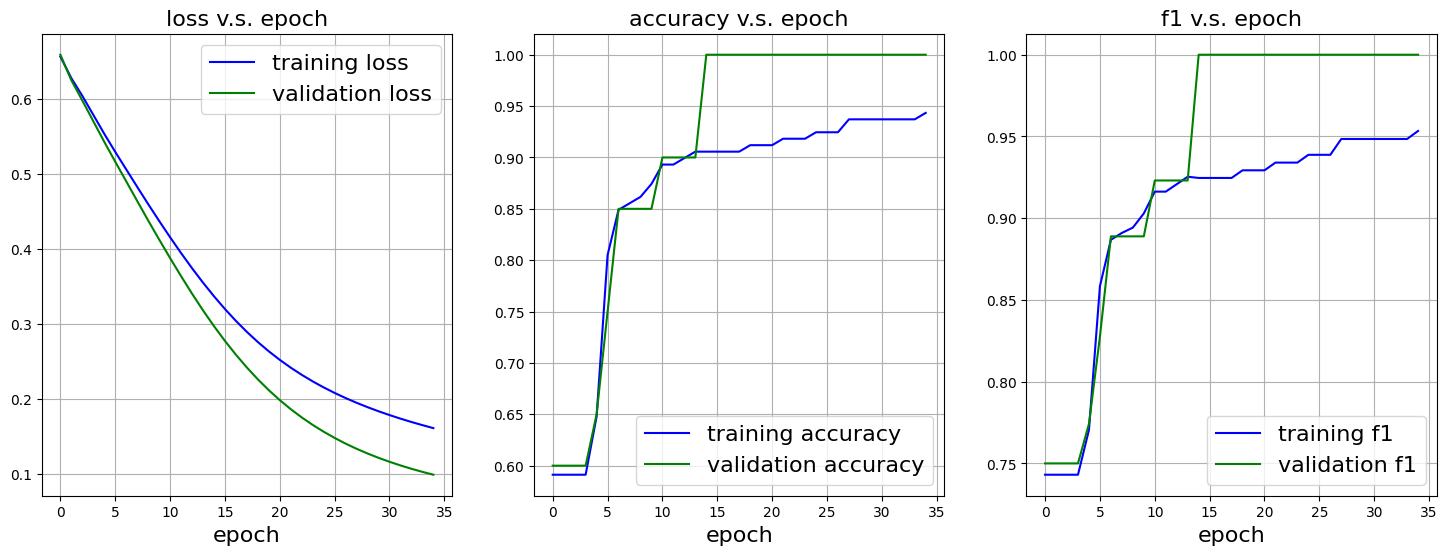

Training complete in 0m 23s. Epoch returned: 14 (best)
Returned train 	Loss: 0.3365 	Acc: 0.9057 	F1: 0.9246 	CM: [52, 13, 2, 92] 	ROC auc: 0.8894 	P/R auc: 0.9337
Returned val 	Loss: 0.2967 	Acc: 1.0000 	F1: 1.0000 	CM: [8, 0, 0, 12] 	ROC auc: 1.0000 	P/R auc: 1.0000


	Example long metrics print: 	Loss: 0.2967 	Acc: 1.0000 	F1: 1.0000 	CM: [8, 0, 0, 12] 	ROC auc: 1.0000 	P/R auc: 1.0000


In [ ]:
full_train_dataloader = dataContainer.get_full_train_dataloader()
final_val_dataloader = dataContainer.get_final_val_dataloader()
test_dataloader = dataContainer.get_test_dataloader()

criterion = torch.nn.BCEWithLogitsLoss()
trainingController = BinaryClassificationTrainingController (criterion=criterion, max_epochs=100, verbose=False)
def optimizer_generator(model): return optim.Adam(model.parameters(), lr=0.00001)

model = MLP_one_hidden_layer(4096, 500, 1)
# model=MLP_two_hidden_layer(512,500,1)

returned_model, val_metrics = trainingController.train_model(model, full_train_dataloader, final_val_dataloader, optimizer=optimizer_generator(model))
trainingController.print_metrics_long(val_metrics, '\n\n\tExample long metrics print:')

#returned_model, returned_epoch, epoch_tracking_list = self.train_model_(model, full_train_dataloader, final_val_dataloader, optimizer=optimizer_generator(model))
#(train_metrics, val_metrics) = epoch_tracking_list[returned_epoch]
#trainingController.print_metrics_long(val_metrics, '\n\n\tExample long metrics print:')